In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=17dc7c7e346745b57e1d20e178fa6f672ffe486f01a7c5deaffad94d32ca42d9
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
# Extração
import os
import tarfile

with tarfile.open("lfw-funneled.tgz", "r:gz") as tar:
    tar.extractall("data/lfw_faces")


In [ ]:
from deepface import DeepFace

25-06-08 16:53:50 - Directory /root/.deepface has been created
25-06-08 16:53:50 - Directory /root/.deepface/weights has been created


In [ ]:
import os
import requests

In [ ]:
# 4. Caminho base das imagens descompactadas
base_path = "data/lfw_faces/lfw_funneled"

In [ ]:
# Construir a árvore após inserir todos os pontos
response = requests.post("https://65f6-2804-14c-7582-80ae-14e7-5fde-5f5-9220.ngrok-free.app/construir-arvore")
print("Construir árvore - Status:", response.status_code, "-", response.text)


Construir árvore - Status: 200 - {"mensagem":"Árvore KD inicializada com sucesso."}


In [ ]:
from tqdm import tqdm

# 2. Inserir embeddings da base LFW
base_path = "lfw_faces/lfw_funneled"
pessoas = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))][:997]

for pessoa in tqdm(pessoas, desc="Inserindo embeddings"):
    imagem_path = os.path.join(base_path, pessoa, os.listdir(os.path.join(base_path, pessoa))[0])
    try:
        embedding = DeepFace.represent(img_path=imagem_path, model_name="Facenet", enforce_detection=False)[0]["embedding"]
        payload = {"embedding": embedding, "id": pessoa}
        response = requests.post(f"https://65f6-2804-14c-7582-80ae-14e7-5fde-5f5-9220.ngrok-free.app/inserir", json=payload)
        if response.status_code != 200:
            print(f"[Erro] {pessoa}: {response.status_code}")
    except Exception as e:
        print(f"[Falha] {pessoa}: {e}")


Inserindo embeddings:   0%|          | 0/997 [00:00<?, ?it/s]

25-06-08 16:54:07 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5

  0%|          | 0.00/92.2M [00:00<?, ?B/s]
 15%|█▌        | 14.2M/92.2M [00:00<00:00, 140MB/s]
 44%|████▍     | 40.4M/92.2M [00:00<00:00, 211MB/s]
 68%|██████▊   | 62.4M/92.2M [00:00<00:00, 214MB/s]
100%|██████████| 92.2M/92.2M [00:00<00:00, 200MB/s]
Inserindo embeddings: 100%|██████████| 997/997 [16:45<00:00,  1.01s/it]


In [ ]:
# 3. Inserir pessoas conhecidas (Beatriz, Gabi e Rose)
def inserir_pessoa(img_path, nome):
    try:
        embedding = DeepFace.represent(img_path=img_path, model_name="Facenet")[0]["embedding"]
        payload = {"embedding": embedding, "id": nome}
        response = requests.post(f"https://65f6-2804-14c-7582-80ae-14e7-5fde-5f5-9220.ngrok-free.app/inserir", json=payload)
        print(f"Enviado {nome} -", response.status_code, response.text)
    except Exception as e:
        print(f"Erro ao enviar {nome}: {e}")

inserir_pessoa("data/rose.jpg", "Rose")
inserir_pessoa("data/beatriz.jpg", "Beatriz")
inserir_pessoa("data/gabi.jpg", "Gabi")

Enviado Rose - 200 {"mensagem":"Pessoa com ID 'Rose' inserida com sucesso."}
Enviado Beatriz - 200 {"mensagem":"Pessoa com ID 'Beatriz' inserida com sucesso."}
Enviado Gabi - 200 {"mensagem":"Pessoa com ID 'Gabi' inserida com sucesso."}


In [ ]:
from PIL import Image

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='suafoto.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

 # Convert the image to RGB mode
  img = Image.open(filename).convert('RGB')
  img.save(filename)
  return filename

In [ ]:
take_photo()

<IPython.core.display.Javascript object>

'suafoto.jpg'

In [ ]:
emb = DeepFace.represent(img_path = "suafoto.jpg", model_name = 'Facenet')

In [ ]:
len(emb)

2

In [ ]:
emb[0]

{'embedding': [0.19685903191566467,
  0.16032908856868744,
  -0.04693831503391266,
  -1.6218994855880737,
  -0.1236320212483406,
  -2.3931219577789307,
  -1.11943781375885,
  2.5850985050201416,
  -1.008338451385498,
  0.34951192140579224,
  -2.285953998565674,
  -0.4331112504005432,
  0.9179617166519165,
  1.2586554288864136,
  0.8577529191970825,
  -1.5152587890625,
  -1.1682446002960205,
  -0.9837407469749451,
  -0.5475578308105469,
  -2.072936773300171,
  -1.7194616794586182,
  -0.02395719662308693,
  0.4962065815925598,
  1.663644552230835,
  0.22976543009281158,
  1.014343023300171,
  -0.5519046783447266,
  0.16884943842887878,
  1.4582133293151855,
  -1.14875066280365,
  -1.639316439628601,
  -0.38698920607566833,
  -0.028069928288459778,
  0.2341410517692566,
  -0.06896697729825974,
  -0.9527778625488281,
  0.09494715929031372,
  1.8144385814666748,
  0.44429510831832886,
  -0.7951853275299072,
  0.5824432969093323,
  0.9981796145439148,
  -0.02553759515285492,
  0.545349955558

In [ ]:
len(emb[0]['embedding'])

128

In [ ]:
faces = DeepFace.extract_faces(img_path = "suafoto.jpg")

In [ ]:
from PIL import Image
img = Image.open("suafoto.jpg")  # Load the original image
faces_list = []
for face in faces:
    x, y, w, h = face['facial_area']['x'], face['facial_area']['y'], face['facial_area']['w'], face['facial_area']['h']
    face_patch = img.crop((x, y, x + w, y + h))
    faces_list.append(face_patch)

In [ ]:
len(faces_list)

2

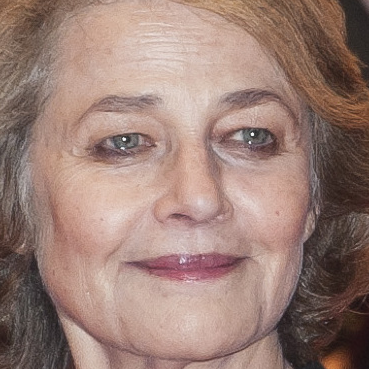

In [ ]:
faces_list[0]

In [ ]:
print(len(faces_list))

2


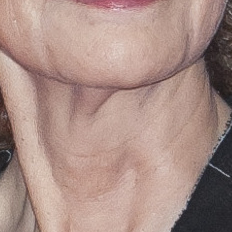

In [ ]:
faces_list[1]

In [ ]:
faces_list[0].save("face1.jpg")

In [ ]:
emb = DeepFace.represent(img_path = "face1.jpg", model_name = 'Facenet')

In [ ]:
len(emb[0]['embedding'])

128

In [ ]:
embedding = emb[0]['embedding']

In [ ]:
!pip install requests

In [ ]:
import requests

In [ ]:
api_url = "https://65f6-2804-14c-7582-80ae-14e7-5fde-5f5-9220.ngrok-free.app/buscar"

payload = {
    "embedding": embedding,
    "id": "teste"
}
response = requests.post(api_url, json=payload)
print("Status /buscar:", response.status_code)
print("Resposta bruta:", response.text)

try:
    resultado = response.json()
    print("ID retornado:", resultado.get("id", resultado.get("erro")))
except:
    print("Falha ao decodificar JSON:", response.text)


Status /buscar: 200
Resposta bruta: {"id":"Charlotte_Rampling"}
ID retornado: Charlotte_Rampling
